In [36]:
import torch 
import pandas as pd 
import seaborn as sns 

In [37]:
import matplotlib.pyplot as plt 
import json
import re 

In [38]:
property_data = pd.read_csv(r'datasets/datasets/property_data_set.csv') 
property_interactions = pd.read_csv(r'datasets/datasets/property_interactions.csv') 
property_photos = pd.read_csv(r'datasets/datasets/property_photos.tsv', sep = "\t")

In [39]:
property_data.shape

(28888, 21)

In [40]:
property_data.columns

Index(['property_id', 'type', 'activation_date', 'bathroom', 'floor',
       'total_floor', 'furnishing', 'gym', 'latitude', 'longitude',
       'lease_type', 'lift', 'locality', 'parking', 'property_age',
       'property_size', 'swimming_pool', 'pin_code', 'rent', 'deposit',
       'building_type'],
      dtype='object')

In [41]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 10)

In [42]:
property_data.head()

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,lease_type,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type
0,ff808081469fd6e20146a5af948000ea,BHK2,09-03-2017 14:36,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP
1,ff8080814702d3d10147068359d200cd,BHK2,07-03-2017 12:02,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,FAMILY,1,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP
2,ff808081470c645401470fb03f5800a6,BHK2,10-03-2017 13:43,2,0,4.0,NOT_FURNISHED,1,12.975072,77.665865,ANYONE,1,GM Palya,FOUR_WHEELER,0,1200,0,560075.0,15000,75000,AP
3,ff808081470c6454014715eaa5960281,BHK3,09-03-2017 22:16,2,3,4.0,SEMI_FURNISHED,0,12.888169,77.591282,ANYONE,0,Arakere,BOTH,1,1300,0,560076.0,17000,150000,AP
4,ff808081474aa867014771a0298f0aa6,BHK1,15-03-2017 18:29,1,1,2.0,SEMI_FURNISHED,0,12.990243,77.712962,ANYONE,0,Hoodi,BOTH,4,450,0,560048.0,6500,40000,IF


In [43]:
property_interactions

,property_id,request_date
0,ff808081469fd6e20146a5af948000ea,2017-03-10 17:42:34
1,ff808081469fd6e20146a5af948000ea,2017-03-09 15:51:17
2,ff808081469fd6e20146a5af948000ea,2017-03-10 17:30:22
3,ff808081469fd6e20146a5af948000ea,2017-03-11 17:48:46
4,ff8080814702d3d10147068359d200cd,2017-03-30 19:59:15
...,...,...
170606,ff8081815b2007fc015b201c77a20395,2017-04-03 16:13:55
170607,ff8081815b2007fc015b201c77a20395,2017-04-02 21:54:14
170608,ff8081815b2007fc015b201c77a20395,2017-04-09 11:33:14
170609,ff8081815b2007fc015b201c77a20395,2017-04-04 10:01:12


In [44]:
def fix_photo_element(photo_element):
    if not photo_element: 
        return 0
    photo_element = photo_element.replace("\\",'') 
    photo_element = re.sub("title",r'"title',photo_element,count=1).strip("\"")
    return len(json.loads(photo_element))

In [45]:
property_photos['photo_urls'] = property_photos['photo_urls'].fillna(value='')
property_photos['photo_count'] = property_photos['photo_urls'].apply(fix_photo_element)

In [46]:
property_photos = property_photos.groupby('property_id')['photo_count'].sum().reset_index()

In [47]:
property_data['activation_date'] = pd.to_datetime(property_data['activation_date'], format = '%d-%m-%Y %H:%M')
property_interactions['request_date'] = pd.to_datetime(property_interactions['request_date'], format = '%Y-%m-%d %H:%M:%S')

In [48]:
num_req = pd.merge(
    property_data[["property_id", "activation_date"]],
    property_interactions,
    on="property_id",
    how="left",
)

In [49]:
num_req['request_day'] = num_req['request_date'] - num_req['activation_date']

num_req['request_day'] = num_req['request_day'].dt.total_seconds() / (60 * 60 * 24)

In [50]:
num_req['within_three_flag'] = num_req['request_day'] <= 3 
num_req['within_seven_flag'] = num_req['request_day'] <= 7 

In [51]:
request_day_within_3d = (
    num_req.groupby("property_id")
    .agg({"within_three_flag": "sum"})
    .reset_index()
    .rename(columns={"within_three_flag": "request_day_within_3d"})
)


request_day_within_7d = (
    num_req.groupby("property_id")
    .agg({"within_three_flag": "sum"})
    .reset_index()
    .rename(columns={"within_three_flag": "request_day_within_7d"})
)

In [52]:
request_day_within_3d

,property_id,request_day_within_3d
0,ff808081469fd6e20146a5af948000ea,4
1,ff8080814702d3d10147068359d200cd,3
2,ff808081470c645401470fb03f5800a6,15
3,ff808081470c6454014715eaa5960281,5
4,ff808081474aa867014771a0298f0aa6,25
...,...,...
28883,ff8081815b1fdda8015b1fe675ae0146,5
28884,ff8081815b1fdda8015b1ffee8a305d2,2
28885,ff8081815b1fdda8015b2000369205fd,0
28886,ff8081815b200540015b20158b0103c9,2


In [53]:
request_day_within_7d

,property_id,request_day_within_7d
0,ff808081469fd6e20146a5af948000ea,4
1,ff8080814702d3d10147068359d200cd,3
2,ff808081470c645401470fb03f5800a6,15
3,ff808081470c6454014715eaa5960281,5
4,ff808081474aa867014771a0298f0aa6,25
...,...,...
28883,ff8081815b1fdda8015b1fe675ae0146,5
28884,ff8081815b1fdda8015b1ffee8a305d2,2
28885,ff8081815b1fdda8015b2000369205fd,0
28886,ff8081815b200540015b20158b0103c9,2


In [54]:

    

def create_request_bucket(value): 
    if value == 0: 
        return 'equals_0' 
    elif value > 0 and value <= 1: 
        return '0_to_1'
    elif value > 1 and value <= 2: 
        return '1_to_2'
    elif value > 2 and value <= 5: 
        return '3_to_5' 
    else: 
        return 'above_5'
    


In [55]:
request_day_within_3d['3d_class'] = request_day_within_3d['request_day_within_3d'].apply(create_request_bucket) 
request_day_within_7d['7d_class'] = request_day_within_7d['request_day_within_7d'].apply(create_request_bucket) 


In [56]:
label_data = pd.merge(request_day_within_7d, request_day_within_3d, on='property_id', how = 'left')

In [57]:
df = pd.merge(property_data, property_photos, on='property_id', how = 'left')

In [58]:
df = pd.merge(df,label_data, on='property_id', how = 'left')

In [59]:
locality_mapping = df[['pin_code','locality']].dropna().drop_duplicates()

locality_mapping_dict = dict(zip(locality_mapping['locality'], locality_mapping['pin_code']))

In [60]:
df['pin_code'] = df['locality'].map(locality_mapping_dict)

In [61]:
df['locality'].value_counts()

locality
Whitefield                                                       745
JP Nagar                                                         655
Electronic City                                                  630
Ramamurthy Nagar                                                 522
Marathahalli                                                     494
                                                                ... 
Rajarajeshwari Nagar, Bengaluru, Karnataka, India                  1
Chinnayanpalya                                                     1
Kondhwa                                                            1
GangaNagar                                                         1
St Marks Rd, Sampangi Rama Nagar, Bengaluru, Karnataka, India      1
Name: count, Length: 2368, dtype: int64

In [62]:
df = df.drop(columns=['property_id','activation_date','locality','pin_code'])

In [63]:
df

,type,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,lease_type,lift,parking,property_age,property_size,swimming_pool,rent,deposit,building_type,photo_count,request_day_within_7d,7d_class,request_day_within_3d,3d_class
0,BHK2,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,BOTH,2,850,1,12000,120000,AP,7,4,3_to_5,4,3_to_5
1,BHK2,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,FAMILY,1,BOTH,1,1233,1,20000,150000,AP,0,3,3_to_5,3,3_to_5
2,BHK2,2,0,4.0,NOT_FURNISHED,1,12.975072,77.665865,ANYONE,1,FOUR_WHEELER,0,1200,0,15000,75000,AP,12,15,above_5,15,above_5
3,BHK3,2,3,4.0,SEMI_FURNISHED,0,12.888169,77.591282,ANYONE,0,BOTH,1,1300,0,17000,150000,AP,9,5,3_to_5,5,3_to_5
4,BHK1,1,1,2.0,SEMI_FURNISHED,0,12.990243,77.712962,ANYONE,0,BOTH,4,450,0,6500,40000,IF,7,25,above_5,25,above_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28883,BHK2,1,0,2.0,SEMI_FURNISHED,0,12.942613,77.621890,FAMILY,0,BOTH,15,1200,0,23000,200000,IF,0,5,3_to_5,5,3_to_5
28884,BHK3,2,3,3.0,SEMI_FURNISHED,0,12.906331,77.591790,FAMILY,1,BOTH,8,1310,0,22000,125000,AP,7,2,1_to_2,2,1_to_2
28885,BHK2,2,6,14.0,SEMI_FURNISHED,1,12.904363,77.526863,FAMILY,1,BOTH,0,975,1,12500,50000,AP,6,0,equals_0,0,equals_0
28886,BHK2,1,1,2.0,SEMI_FURNISHED,0,12.938007,77.629097,ANYONE,0,TWO_WHEELER,5,600,0,14000,80000,IF,0,2,1_to_2,2,1_to_2


C:\Users\siddharth\AppData\Local\Temp\ipykernel_2012\320819007.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(df, x = 'request_day_within_3d', palette='coolwarm')


<Axes: xlabel='request_day_within_3d', ylabel='Density'>

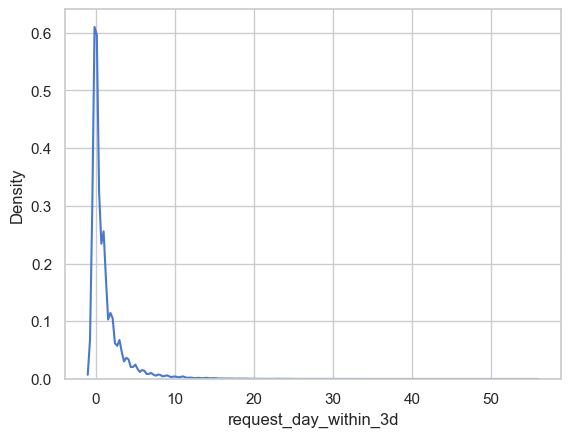

In [64]:
# Set a pleasing theme and color palette
sns.set_theme(style="whitegrid", palette="muted")



sns.kdeplot(df, x = 'request_day_within_3d', palette='coolwarm')

<Axes: xlabel='3d_class', ylabel='count'>

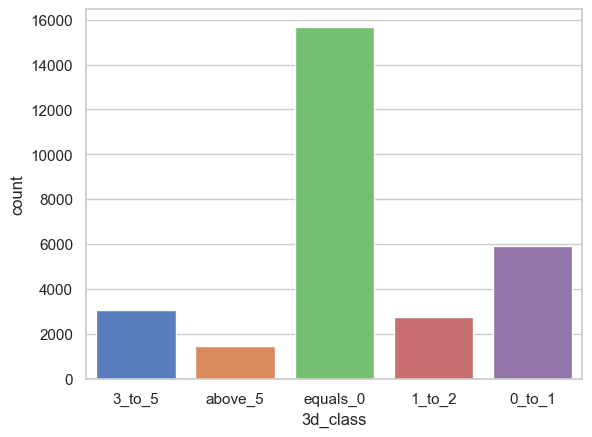

In [65]:
sns.countplot(data=df, x = '3d_class', hue='3d_class')

In [66]:
# performing categorical and numerical analysis 


df_cat = df.select_dtypes(include=['object']) 
df_num = df.select_dtypes(include=['number'])

In [67]:
for col in df_cat: 
    print("Column Name: ", col) 
    print(df_cat[col].value_counts()) 
    print("\n" + "--" * 20)

Column Name:  type
type
BHK2        14071
BHK1         6565
BHK3         5725
RK1          2015
BHK4          440
BHK4PLUS       72
Name: count, dtype: int64

----------------------------------------
Column Name:  furnishing
furnishing
SEMI_FURNISHED     22463
NOT_FURNISHED       4863
FULLY_FURNISHED     1562
Name: count, dtype: int64

----------------------------------------
Column Name:  lease_type
lease_type
FAMILY      14885
ANYONE      12721
BACHELOR     1211
COMPANY        71
Name: count, dtype: int64

----------------------------------------
Column Name:  parking
parking
BOTH            13809
TWO_WHEELER     12806
NONE             1277
FOUR_WHEELER      996
Name: count, dtype: int64

----------------------------------------
Column Name:  building_type
building_type
IF    16557
AP    10193
IH     2059
Name: count, dtype: int64

----------------------------------------
Column Name:  7d_class
7d_class
equals_0    15678
0_to_1       5940
3_to_5       3049
1_to_2       2741
above_5  

Column Name:  type


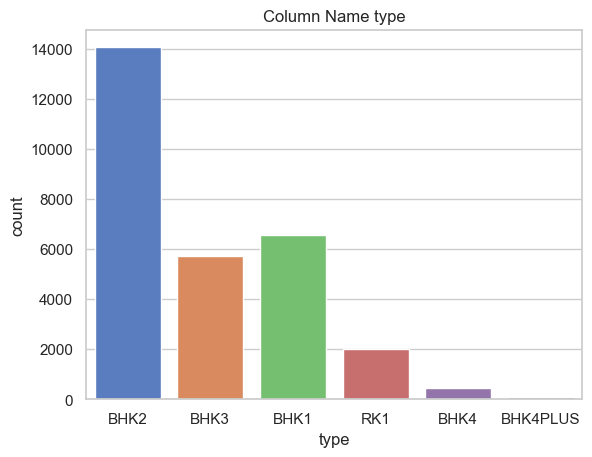

Column Name:  furnishing


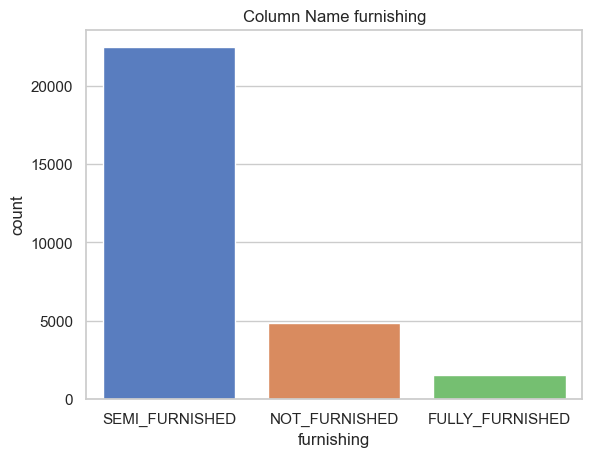

Column Name:  lease_type


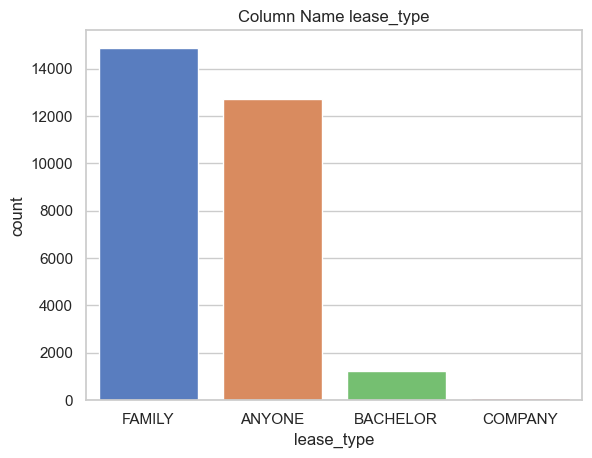

Column Name:  parking


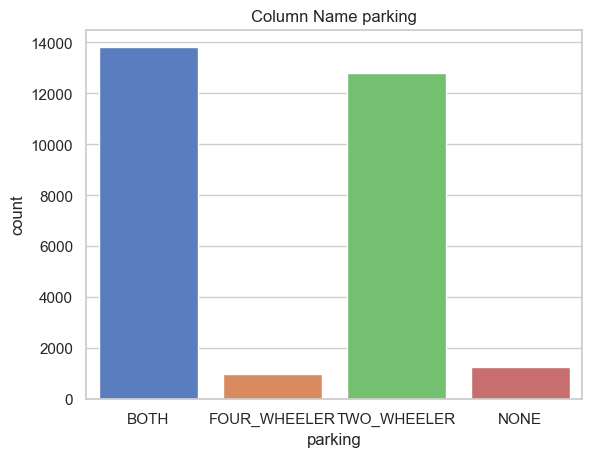

Column Name:  building_type


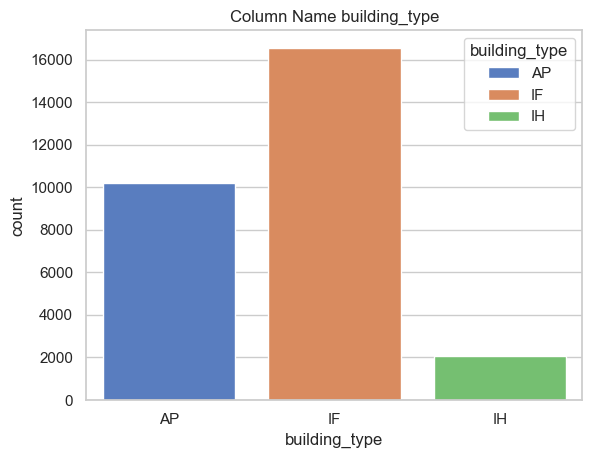

Column Name:  7d_class


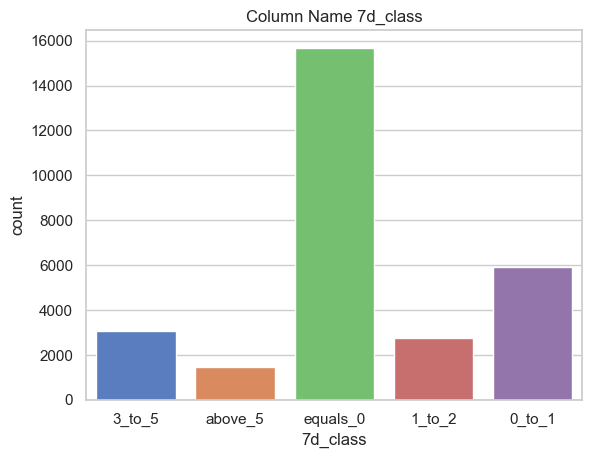

Column Name:  3d_class


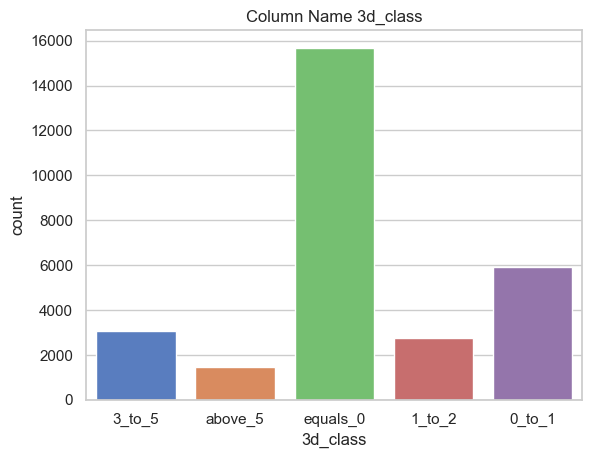

In [68]:
for col in df_cat: 
    print("Column Name: ", col) 
    sns.countplot(data = df, x = col, hue = col)
    plt.title(f'Column Name {col}')
    plt.show()

In [69]:
from sklearn.preprocessing import MinMaxScaler 
scaler_for_num = MinMaxScaler()
df_num_scaled = scaler_for_num.fit_transform(df_num)

df_num_scaled = pd.DataFrame(df_num_scaled) 
df_num_scaled.columns = df_num.columns


melted_df_num = pd.melt(df_num_scaled, var_name='num_variables', value_name='numbers')

<Axes: xlabel='numbers', ylabel='num_variables'>

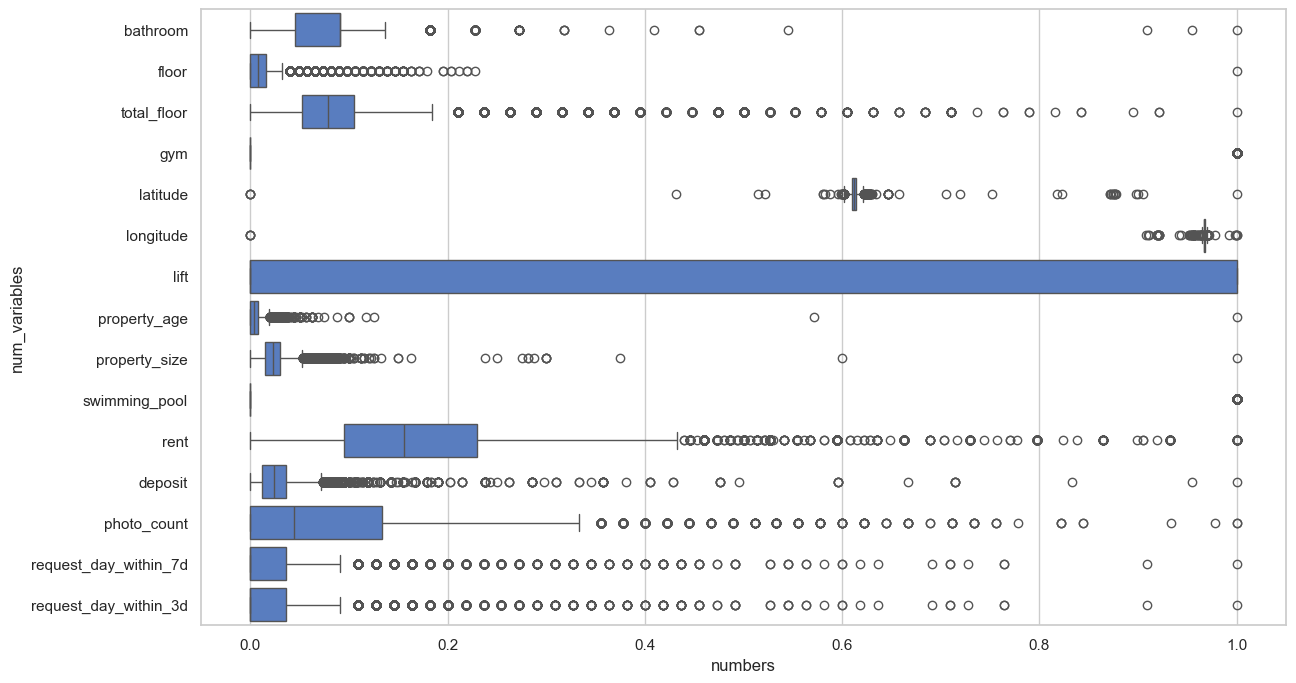

In [70]:
plt.figure(figsize=(14, 8))

sns.boxplot(data=melted_df_num, x = 'numbers', y='num_variables')

In [71]:
df.to_parquet('data.parquet')